In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [2]:
def define_discriminator(image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
	opt = Adam(lr=0.0003, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [3]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [4]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

Generator:    
The encoder-decoder architecture consists of:
encoder:
C64-C128-C256-C512-C512-C512-C512
decoder:
CD512-CD512-C512-C256-C128-C64
Discriminator
C64-C128-C256-C512


In [5]:
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e6, 512)
	d2 = decoder_block(d1, e5, 512)
	d3 = decoder_block(d2, e4, 512, dropout=False)
	d4 = decoder_block(d3, e3, 256, dropout=False)
	d5 = decoder_block(d4, e2, 128, dropout=False)
	d6 = decoder_block(d5, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6) #Modified 
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

In [6]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0003, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [7]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [8]:
# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_train.h5'
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [9]:

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

Loaded:  (400, 256, 256, 3) (400, 256, 256, 3)


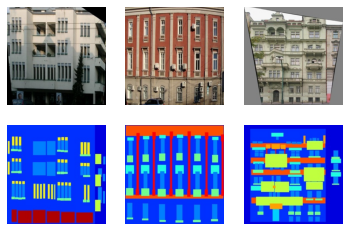

In [11]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = 'H:/deep/facades/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)


n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

Train the Model

In [12]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [src_images, tar_images]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=20, n_batch=1) 

D:\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d1[0.357] d2[0.860] g[80.448]
>2, d1[0.969] d2[1.156] g[74.263]
>3, d1[0.369] d2[0.752] g[70.486]
>4, d1[0.453] d2[0.629] g[74.634]
>5, d1[0.705] d2[0.515] g[76.764]
>6, d1[0.651] d2[0.489] g[74.211]
>7, d1[0.550] d2[0.490] g[68.567]
>8, d1[0.600] d2[0.426] g[72.458]
>9, d1[0.417] d2[0.444] g[64.417]
>10, d1[0.425] d2[0.419] g[65.025]
>11, d1[0.390] d2[0.380] g[61.940]
>12, d1[0.398] d2[0.399] g[62.436]
>13, d1[0.452] d2[0.415] g[58.136]
>14, d1[0.434] d2[0.401] g[53.280]
>15, d1[0.406] d2[0.449] g[67.177]
>16, d1[0.354] d2[0.448] g[53.417]
>17, d1[0.445] d2[0.394] g[54.103]
>18, d1[0.412] d2[0.411] g[51.058]
>19, d1[0.456] d2[0.342] g[53.929]
>20, d1[0.394] d2[0.376] g[48.741]
>21, d1[0.360] d2[0.355] g[41.829]
>22, d1[0.403] d2[0.336] g[61.702]
>23, d1[0.429] d2[0.359] g[51.300]
>24, d1[0.387] d2[0.326] g[48.524]
>25, d1[0.381] d2[0.313] g[40.839]
>26, d1[0.282] d2[0.354] g[44.235]
>27, d1[0.238] d2[0.304] g[37.485]
>28, d1[0.243] d2[0.305] g[33.146]
>29, d1[0.404] d2[0.277] g[49

In [13]:
#Reports parameters for each batch (total 400) for each epoch.
#For 10 epochs we should see 4000

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

#Reports parameters for each batch (total 4000) for each epoch.
#For 10 epochs we should see 4000


Execution time is:  1:49:04.242523


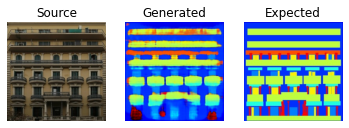

In [14]:
#Test trained model on a few images...

from keras.models import load_model
from numpy.random import randint
model = load_model('model_train.h5')

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()


[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

Generate Result for School library Building


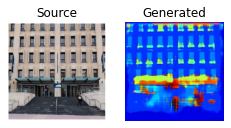

In [15]:
#generate image for school library
path2 = path = 'H:/deep/facades/mytest1/'
my_src_image, my_tar_image =load_images(path2)
# # load and prepare training images
my_data = [my_src_image, my_tar_image]

my_dataset = preprocess_data(my_data)


# plot source, generated and target images
def plot_images(src_img, gen_img):
	images = vstack((src_img, gen_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

[my_X1, my_X2] = my_dataset
# select random example
my_ix = randint(0, len(my_X1), 1)
my_src_image, my_tar_image = my_X1[my_ix], my_X2[my_ix]
# generate image from source
my_gen_image = model.predict(my_src_image)

# plot all three images
plot_images(my_src_image, my_gen_image)





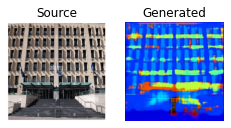

In [16]:
#generate image for school library
path2 = path = 'H:/deep/facades/mytest2/'
my_src_image, my_tar_image =load_images(path2)
# # load and prepare training images
my_data = [my_src_image, my_tar_image]

my_dataset = preprocess_data(my_data)


# plot source, generated and target images
def plot_images(src_img, gen_img):
	images = vstack((src_img, gen_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

[my_X1, my_X2] = my_dataset
# select random example
my_ix = randint(0, len(my_X1), 1)
my_src_image, my_tar_image = my_X1[my_ix], my_X2[my_ix]
# generate image from source
my_gen_image = model.predict(my_src_image)

# plot all three images
plot_images(my_src_image, my_gen_image)